In [1]:
from model import create_model

nn4_small2_pretrained = create_model()

Using TensorFlow backend.


In [2]:
nn4_small2_pretrained.load_weights('weights/nn4.small2.v1.h5')

In [3]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('images')
print('metadata created')
print(metadata)

metadata created
[images/Colin_Powell/Colin_Powell_0004.jpg
 images/Colin_Powell/Colin_Powell_0006.jpg
 images/Colin_Powell/Colin_Powell_0005.jpg
 images/Colin_Powell/Colin_Powell_0008.jpg
 images/Colin_Powell/Colin_Powell_0001.jpg
 images/Colin_Powell/Colin_Powell_0003.jpg
 images/Colin_Powell/Colin_Powell_0007.jpg
 images/Colin_Powell/Colin_Powell_0002.jpg
 images/Colin_Powell/Colin_Powell_0010.jpg
 images/Colin_Powell/Colin_Powell_0009.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0005.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0002.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0006.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0007.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0001.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0004.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0010.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0003.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0009.jpg
 ima

In [4]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]


alignment = AlignDlib('shape_predictor_68_face_landmarks.dat')

#combined transformation
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [ ]:
embedded = np.zeros((metadata.shape[0], 128))
real_name = {}

for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    img = align_image(img)
    # scale RGB values to interval [0,1]
    if img is not None:
        img = (img / 255.).astype(np.float32)
        # obtain embedding vector for image
        embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
        real_name[os.path.dirname(m.image_path()[7:])] = embedded[i]

def real_names():
    return real_name

In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

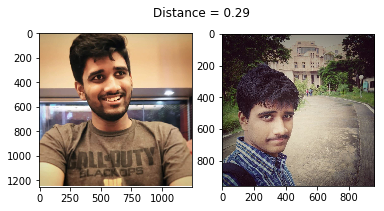

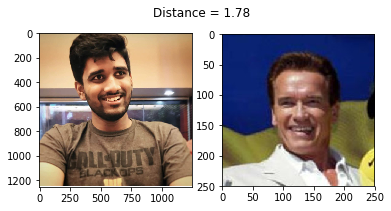

In [ ]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(6,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(43, 42)
show_pair(43, 18)

In [ ]:
def recognize(embedded):
    min_dist = 100
    _id = None
    for name,emb in real_name.items():
        dist = np.sum(np.square(emb - embedded))


        if dist < min_dist:
            min_dist = dist
            _id = name
    if min_dist > 0.58:
        print(min_dist)
        return None
    else:
        print(min_dist)
        return _id

    

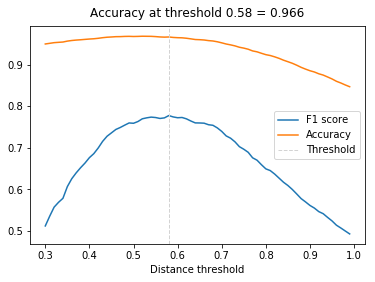

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

In [ ]:
embedded = np.zeros((1, 128))


def recognize_image(image_path):
    img = load_image(image_path)
    img = align_image(img)
    if img is not None:
        img = (img / 255.).astype(np.float32)
        # obtain embedding vector for image
        embedded = nn4_small2_pretrained.predict(np.expand_dims(np.array(img), axis=0))[0]
        name = recognize(embedded)
        print(name)
        return name
    return None


cap = cv2.VideoCapture(0)


# def webcam_recognize():
#     while(True): 
#         ret, frame = cap.read()
#         cv2.imwrite('temp.jpg',frame)
#         cv2.waitKey(20)
#         if 'temp.jpg' is not None:
#             name = recognize_image('temp.jpg')
#             cv2.imshow('temp',frame)
#             print(name)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
        
#     cap.release()
#     cv2.destroyAllWindows()


    
# webcam_recognize()
# recognize_image('.jpg')

from mtcnn.mtcnn import MTCNN
def multiple_recognize():
    while(True):
        ret,frame = cap.read()
        cv2.imwrite('temp.jpg',frame)
        detector = MTCNN()
        image = load_image('temp.jpg')
        faces = detector.detect_faces(image)
        print(faces)
        if faces is not None:
            for face in faces:
                (x,y,w,h) = face['box']
                cv2.imwrite('temp.jpg',frame)
                if 'temp.jpg' is not None:
                    name = recognize_image('temp.jpg')
                    cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),5)
                    cv2.putText(frame, name , (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
                    cv2.imshow('Faces',frame)
                    
                    
                      
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
                
#                 cv2.imshow('parts',image[y:y+h,x:x+w])

multiple_recognize()


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
[]
[]
[]
[]
[]
[{'box': [244, 292, 142, 184], 'confidence': 0.9995641112327576, 'keypoints': {'left_eye': (279, 360), 'right_eye': (343, 357), 'nose': (307, 397), 'mouth_left': (286, 434), 'mouth_right': (340, 432)}}]
0.8688680429408873
None
[{'box': [244, 293, 141, 185], 'confidence': 0.9998728036880493, 'keypoints': {'left_eye': (284, 361), 'right_eye': (349, 358), 'nose': (319, 396), 'mouth_left': (293, 433), 'mouth_right': (349, 431)}}]
1.0939144620875596
None
[{'box': [252, 308, 137, 174], 'confidence': 0.9999438524246216, 'keypoints': {'left_eye': (293, 368), 'right_eye': (358, 366), 'nose': (327, 401), 'mouth_left': (302, 436), 'mouth_right': (355, 436)}}]
1.0760540099587859
None
[{'box': [194, 301, 142, 178], 'confidence': 0.9993700385093689, 'keypoints': {'left_eye': (238, 368), 'right_eye': (303, 361), 'nose': (276, 403), 'mouth_lef

0.6968763480832466
None
0.8215970213809378
None
[{'box': [510, 340, 120, 139], 'confidence': 0.9999759197235107, 'keypoints': {'left_eye': (549, 391), 'right_eye': (606, 383), 'nose': (585, 404), 'mouth_left': (564, 444), 'mouth_right': (612, 437)}}, {'box': [232, 209, 144, 185], 'confidence': 0.9999693632125854, 'keypoints': {'left_eye': (276, 280), 'right_eye': (342, 274), 'nose': (315, 316), 'mouth_left': (287, 352), 'mouth_right': (343, 347)}}]
0.6731727622954036
None
0.6731727622954036
None
[{'box': [238, 210, 140, 181], 'confidence': 0.9999933242797852, 'keypoints': {'left_eye': (281, 280), 'right_eye': (345, 276), 'nose': (320, 316), 'mouth_left': (292, 350), 'mouth_right': (346, 346)}}, {'box': [511, 333, 121, 142], 'confidence': 0.999925971031189, 'keypoints': {'left_eye': (545, 389), 'right_eye': (601, 378), 'nose': (579, 399), 'mouth_left': (563, 441), 'mouth_right': (609, 433)}}]
0.6130636409557497
None
0.8105132217734193
None
[{'box': [506, 344, 122, 138], 'confidence': 0.

0.6831119859628689
None
0.6831119859628689
None
[{'box': [494, 349, 115, 137], 'confidence': 0.9998718500137329, 'keypoints': {'left_eye': (521, 405), 'right_eye': (573, 392), 'nose': (549, 418), 'mouth_left': (534, 453), 'mouth_right': (585, 441)}}, {'box': [233, 248, 110, 148], 'confidence': 0.9995337724685669, 'keypoints': {'left_eye': (293, 300), 'right_eye': (334, 308), 'nose': (327, 334), 'mouth_left': (289, 359), 'mouth_right': (322, 365)}}]
1.0672981630289606
None
1.0672981630289606
None
[{'box': [230, 243, 119, 154], 'confidence': 0.9994958639144897, 'keypoints': {'left_eye': (296, 299), 'right_eye': (338, 306), 'nose': (332, 337), 'mouth_left': (290, 360), 'mouth_right': (324, 366)}}, {'box': [485, 352, 112, 127], 'confidence': 0.9994675517082214, 'keypoints': {'left_eye': (512, 406), 'right_eye': (561, 395), 'nose': (532, 421), 'mouth_left': (522, 450), 'mouth_right': (568, 442)}}]
0.8260091293346261
None
0.8260091293346261
None
[{'box': [492, 356, 116, 129], 'confidence': 0

1.0615111314661934
None
[{'box': [285, 263, 109, 147], 'confidence': 0.9993159770965576, 'keypoints': {'left_eye': (351, 315), 'right_eye': (387, 322), 'nose': (384, 350), 'mouth_left': (344, 373), 'mouth_right': (373, 377)}}, {'box': [492, 369, 116, 132], 'confidence': 0.9992582201957703, 'keypoints': {'left_eye': (521, 422), 'right_eye': (573, 412), 'nose': (545, 439), 'mouth_left': (533, 473), 'mouth_right': (580, 465)}}]
[{'box': [490, 358, 119, 132], 'confidence': 0.9995587468147278, 'keypoints': {'left_eye': (522, 412), 'right_eye': (576, 402), 'nose': (550, 428), 'mouth_left': (534, 460), 'mouth_right': (585, 451)}}, {'box': [287, 252, 108, 143], 'confidence': 0.9981264472007751, 'keypoints': {'left_eye': (349, 302), 'right_eye': (387, 313), 'nose': (380, 340), 'mouth_left': (342, 362), 'mouth_right': (371, 370)}}]
[{'box': [498, 353, 116, 137], 'confidence': 0.9999386072158813, 'keypoints': {'left_eye': (525, 409), 'right_eye': (578, 398), 'nose': (552, 423), 'mouth_left': (537

1.1482726809940658
None
0.999001781816784
None
[{'box': [507, 358, 110, 138], 'confidence': 0.9995126724243164, 'keypoints': {'left_eye': (541, 407), 'right_eye': (590, 422), 'nose': (554, 436), 'mouth_left': (528, 460), 'mouth_right': (566, 472)}}, {'box': [285, 244, 106, 145], 'confidence': 0.9972276091575623, 'keypoints': {'left_eye': (348, 294), 'right_eye': (381, 303), 'nose': (377, 330), 'mouth_left': (341, 352), 'mouth_right': (368, 359)}}]
1.130728539445042
None
1.1818580421939429
None
[{'box': [508, 357, 111, 137], 'confidence': 0.9978970289230347, 'keypoints': {'left_eye': (543, 404), 'right_eye': (593, 421), 'nose': (557, 435), 'mouth_left': (530, 457), 'mouth_right': (568, 470)}}]
1.112699949866183
None
[{'box': [508, 362, 106, 130], 'confidence': 0.9995494484901428, 'keypoints': {'left_eye': (543, 405), 'right_eye': (589, 422), 'nose': (555, 437), 'mouth_left': (528, 459), 'mouth_right': (564, 471)}}, {'box': [273, 254, 114, 155], 'confidence': 0.9995218515396118, 'keypoin

In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials


def mark_attendance():
    scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
    creds = ServiceAccountCredentials.from_json_keyfile_name('client_secret.json', scope)
    client = gspread.authorize(creds)
    
    sheet = client.open('Attendance').sheet1
    
    attendance = sheet.get_all_records()
    print(attendance)
    
mark_attendance()

TimeoutError: [Errno 110] Connection timed out